In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps

## Funciones

In [2]:
def open_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error al abrir el video")
        exit()
    return cap

def get_video_frames(cap, num_frames = None):
    if not num_frames: num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            print(f"Error al leer el fotograma {i + 1}")
            break
        frames.append(frame)
    cap.release()
    return frames

def frame_imshow_vis(image, tit = 'image'):
    cv2.imshow(tit, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def frame_plt_vis(image, fsize = (8, 8)):
    f, ax = plt.subplots(figsize=fsize)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    return ax

def obtain_temp(image):
    temp = np.mean(image)
    return -(100/255)*temp+100

def get_colors_to_gray(colors_n, vis=False):
    cmap = colormaps["jet"]
    gray_values = np.linspace(0, 255, colors_n, dtype=int)
    jet_colors = (cmap(gray_values)[:,:3]*255).astype(int)
    color_to_gray_map = dict(zip(map(tuple, jet_colors), gray_values))

    if vis:
        colors_normalized = jet_colors / 255.0
        x = np.arange(len(jet_colors))
        y = np.ones(len(jet_colors))
        plt.figure(figsize=(10, 2))
        plt.scatter(x, y, color=colors_normalized, s=500)  # s is the size of the points
        plt.axis('off')
        plt.show()
    return color_to_gray_map

def closest_color(pixel_color, colors_to_gray):
    colors = list(colors_to_gray.keys())
    distances = np.sqrt(np.sum((np.array(colors) - np.array(pixel_color))**2, axis=1))
    closest_index = np.argmin(distances)
    return list(colors_to_gray.values())[closest_index]

def get_gray_scale_image(image, colors_to_gray):
    out_im = np.zeros(image.shape[:2], dtype=np.uint8)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_color = tuple(image[y, x])
            gray_value = closest_color(pixel_color, colors_to_gray)
            out_im[y, x] = gray_value
    return out_im

def crop_image(image, center, size, vis=False):
    x, y = center
    a, b = size
    
    # Coordenadas del rectángulo
    x_min, x_max = int(x - a / 2), int(x + a / 2)
    y_min, y_max = int(y - b / 2), int(y + b / 2)

    c_image = image[y_min:y_max, x_min:x_max]

    if vis:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), facecolor='.85')
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                linewidth=1, edgecolor='black', facecolor='none')
        ax1.add_patch(rect)

        ax2.imshow(cv2.cvtColor(c_image, cv2.COLOR_BGR2RGB))
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_aspect('equal')

        plt.tight_layout()

        # ----------- FORZAR AX2 A SER UN CUADRADO -----------------
        bbox1 = ax1.get_position()
        h = bbox1.height
        bbox2 = [bbox1.x1 +0, bbox1.y0, h, h]  

        ax2.set_position(bbox2)
        # -----------------------------------------------------------
        plt.show()

    return c_image


def vis_prop_w_mov_av(data, wdw, ylims=None):
    if isinstance(data, list): data = np.array(data)
    mov_av = np.convolve(np.array(data), np.ones(wdw)/wdw, mode='valid')
    range_x = np.arange(len(mov_av)) + (wdw//2)
    f, ax = plt.subplots(figsize=(8, 8))
    ax.plot(data, alpha=.2)
    ax.plot(range_x, mov_av, color='black')
    if ylims: ax.set_ylim(ylims)
    plt.show()

## Abrir video

In [3]:
cap = open_video('../data/video_termo/video_termo_2.wmv')
frames = get_video_frames(cap, num_frames = None)

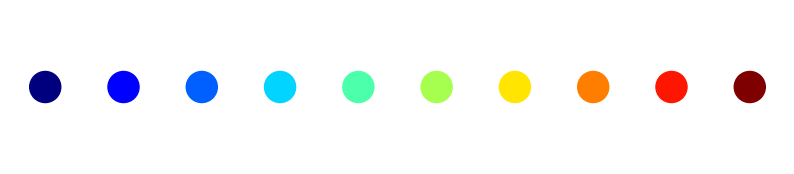

{(0, 0, 127): 0,
 (0, 0, 254): 28,
 (0, 96, 255): 56,
 (0, 212, 255): 85,
 (76, 255, 170): 113,
 (166, 255, 79): 141,
 (255, 229, 0): 170,
 (255, 126, 0): 198,
 (255, 22, 0): 226,
 (127, 0, 0): 255}

In [4]:
colors_to_gray = get_colors_to_gray(10, True)

colors_to_gray

<Axes: >

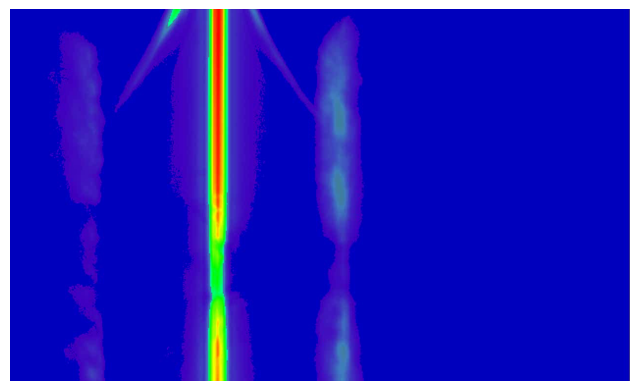

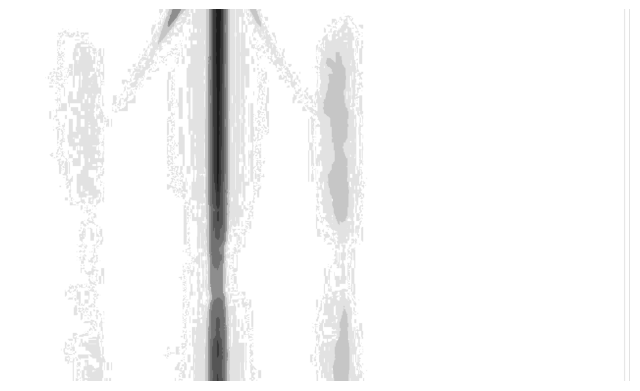

In [7]:
image = frames[0]
frame_plt_vis(image, fsize = (8, 8))
out_im = get_gray_scale_image(image, colors_to_gray)
frame_plt_vis(out_im, fsize = (8, 8))





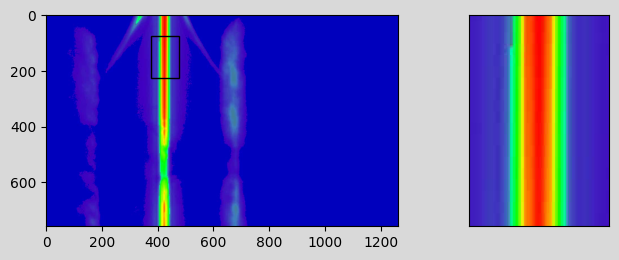

In [5]:
xy = [425,150]
ab = [100, 150]

image = frames[0]
cropped_image = crop_image(image, xy, ab, True)

In [6]:
temps = []
for frame in frames:
    cropped_image = crop_image(frame, xy, ab)
    out_im = get_gray_scale_image(cropped_image, colors_to_gray)
    temps.append(obtain_temp(out_im))

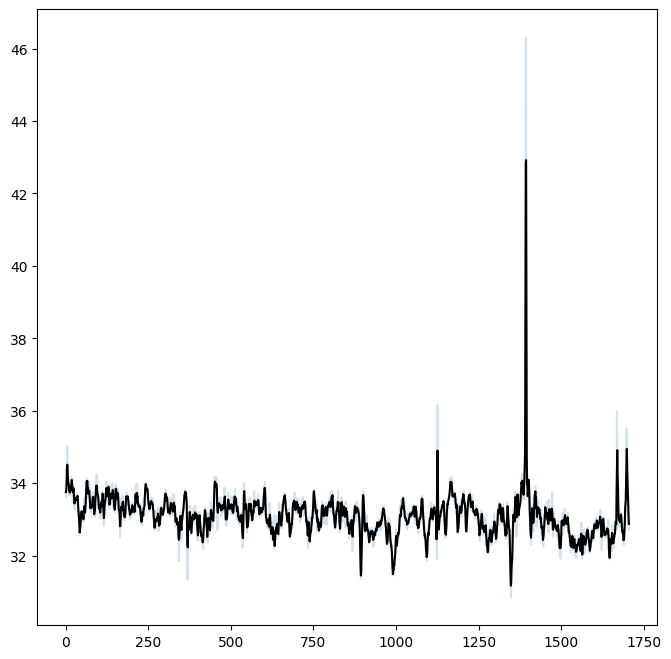

1394


In [7]:
# %matplotlib tk
# %matplotlib inline
vis_prop_w_mov_av(temps,3, ylims=None)
idn = np.argmax(np.array(temps))
print(idn)

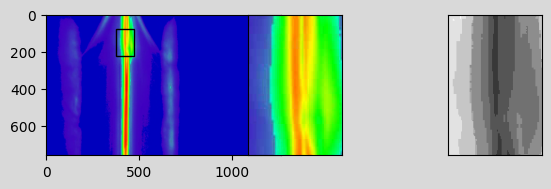

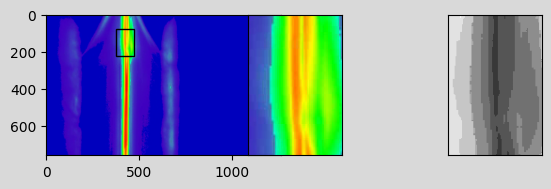

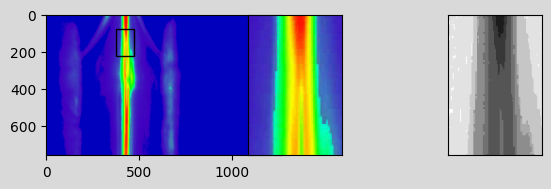

In [8]:
def plot_frame(frames, xy, ab, frame_index):
    image = frames[frame_index]
    x, y = xy
    a, b = ab
    
    # Coordenadas del rectángulo
    x_min, x_max = int(x - a / 2), int(x + a / 2)
    y_min, y_max = int(y - b / 2), int(y + b / 2)

    c_image = image[y_min:y_max, x_min:x_max]
    out_im = get_gray_scale_image(c_image, colors_to_gray)


    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 6), facecolor='.85')
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                            linewidth=1, edgecolor='black', facecolor='none')
    ax1.add_patch(rect)

    ax2.imshow(cv2.cvtColor(c_image, cv2.COLOR_BGR2RGB))
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_aspect('equal')

    ax3.imshow(cv2.cvtColor(out_im, cv2.COLOR_BGR2RGB))
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_aspect('equal')

    plt.tight_layout()

    # ----------- FORZAR AX2 A SER UN CUADRADO -----------------
    bbox1 = ax1.get_position()
    h = bbox1.height
    bbox2 = [bbox1.x1 - .1, bbox1.y0, h, h]  

    ax2.set_position(bbox2)
    bbox3 = [bbox1.x1 +0.15, bbox1.y0, h, h]  

    ax3.set_position(bbox3)
    # -----------------------------------------------------------
    plt.show()

plot_frame(frames, xy, ab, idn-1)
plot_frame(frames, xy, ab, idn)
plot_frame(frames, xy, ab, idn+1)

